In [1]:
%matplotlib inline
import matplotlib
import os
import pandas as pd
import louvain
import igraph as ig

import collections
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from nwtools import communities, common

In [2]:
edges_dict = {}
datapath = '/media/sf_VBox_Shared/networks/trade/import/'
for year in range(1995, 2013):
    edges_dict[str(year)] = pd.read_csv(os.path.join(datapath, 'import-links-{}.csv'.format(year))
                                       , keep_default_na=False)

In [3]:
nodes = pd.read_csv('/media/sf_VBox_Shared/networks/trade/countries.csv', keep_default_na=False,  
                    index_col='Id')

In [4]:
for year in edges_dict:
    edges_dict[year]['Distance'] = 1.0 / edges_dict[year]['Weight']

In [5]:
graphs = {year: common.igraph_from_pandas_edgelist(edges_dict[year], attributes=['Weight', 'Distance'], directed=True)
          for year in edges_dict}

In [6]:
import leidenalg as la

def consensus_partition(g, 
                        partition_type = la.ModularityVertexPartition,
                        weights=None,
                        nr_partitions = 100,
                        threshold = 0,
                        max_nr_iterations = 5,
                       verbose=False, **kwargs):
    '''
    Partitions graph based on consensus clustering
    :param g: igraph Graph
    '''
    n = len(g.vs)
    graph = g
    for j in range(max_nr_iterations):
        if verbose:
            print('Iteration {}'.format(j))

        consensus_matrix = np.zeros((n, n))
        for i in range(nr_partitions):
            partition = la.find_partition(graph, partition_type=partition_type, weights=weights, **kwargs)
            k = len(partition.sizes()) # Number of partitions
            b = np.zeros((n, k))
            b[np.arange(n), partition.membership] = 1
            consensus_matrix += b.dot(b.T)
        consensus_matrix /= nr_partitions

        g2 = graph.copy()
        g2.delete_edges(g2.es)

        consensus_matrix_fixed = consensus_matrix.copy()
        consensus_matrix_fixed[consensus_matrix<=threshold] = 0
        ix, jx = consensus_matrix_fixed.nonzero()
        for i,j in zip(list(ix), list(jx)):
            if i!=j: # is this necessary?
                g2.add_edge(i,j,weight=consensus_matrix_fixed[i,j])
        # are there any solo clusters?
        ccs = g2.clusters()
        if verbose:
            print('Smallest connected component: {}'.format(min(ccs.sizes())))

        # plot adjacency matrix
        if verbose:
            communities.plot_sorted_adjacency(consensus_matrix, partition.membership)
        
        # Check if converged
        if(min(consensus_matrix[consensus_matrix.nonzero()])==1):
            if verbose:
                print('Converged!')
            return consensus_matrix, ccs.membership
        graph = g2
        weights = 'weight'
        
    return consensus_matrix, ccs.membership

Iteration 0
Smallest connected component: 9


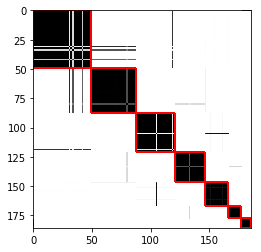

Iteration 1
Smallest connected component: 9


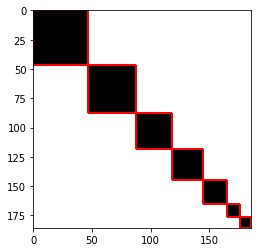

Converged!
Iteration 0
Smallest connected component: 1


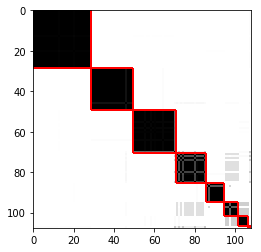

Iteration 1
Smallest connected component: 1


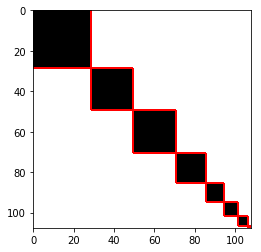

Converged!
Iteration 0
Smallest connected component: 1


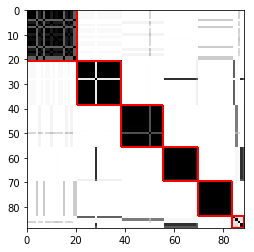

Iteration 1
Smallest connected component: 1


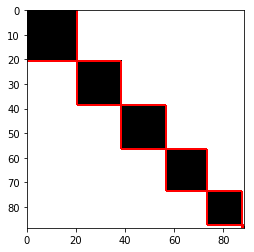

Converged!
Iteration 0
Smallest connected component: 4


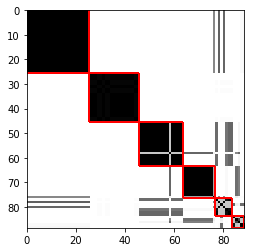

Iteration 1
Smallest connected component: 4


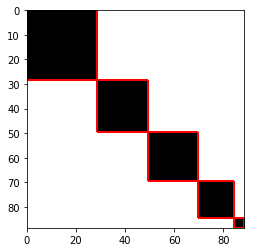

Converged!
Iteration 0
Smallest connected component: 1


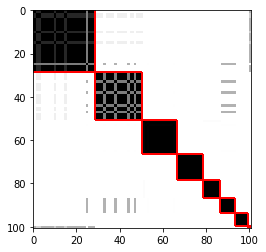

Iteration 1
Smallest connected component: 1


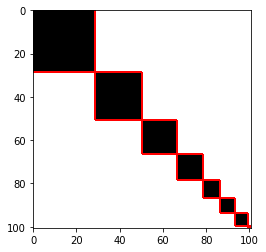

Converged!
Iteration 0
Smallest connected component: 1


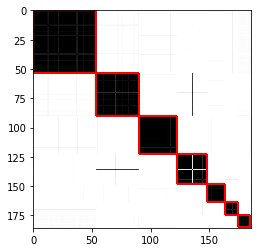

Iteration 1
Smallest connected component: 1


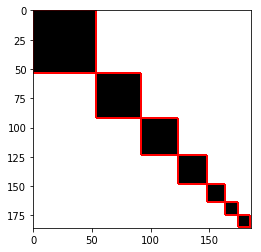

Converged!
Iteration 0
Smallest connected component: 1


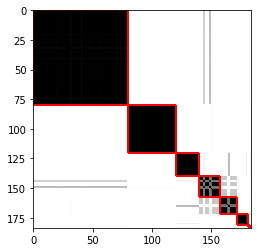

Iteration 1
Smallest connected component: 1


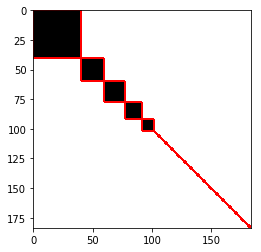

Converged!
Iteration 0
Smallest connected component: 10


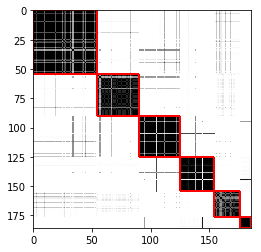

Iteration 1
Smallest connected component: 10


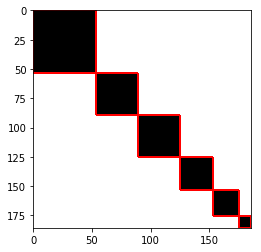

Converged!
Iteration 0
Smallest connected component: 10


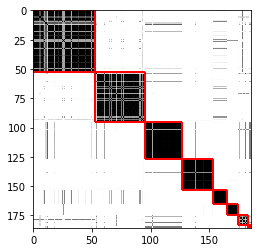

Iteration 1
Smallest connected component: 10


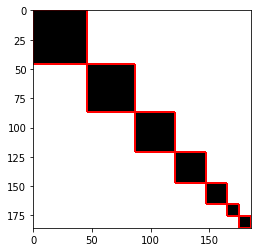

Converged!
Iteration 0
Smallest connected component: 1


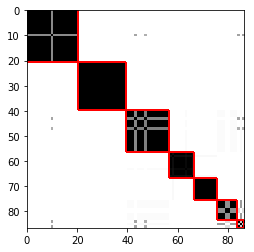

Iteration 1
Smallest connected component: 1


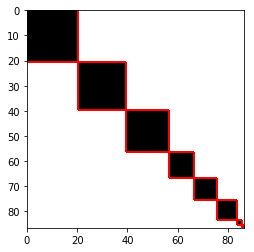

Converged!
Iteration 0
Smallest connected component: 14


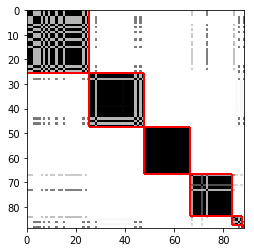

Iteration 1
Smallest connected component: 4


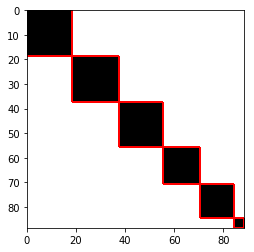

Converged!
Iteration 0
Smallest connected component: 9


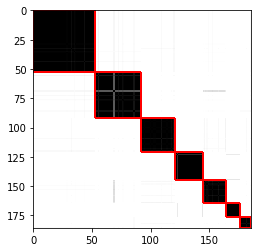

Iteration 1
Smallest connected component: 9


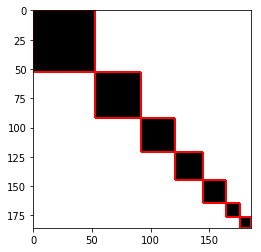

Converged!
Iteration 0
Smallest connected component: 10


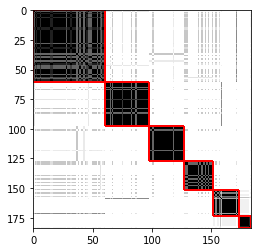

Iteration 1
Smallest connected component: 10


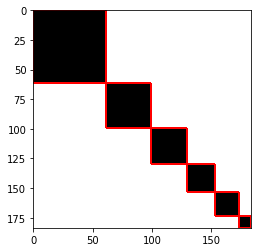

Converged!
Iteration 0
Smallest connected component: 1


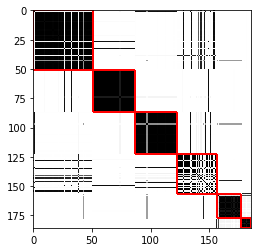

Iteration 1
Smallest connected component: 1


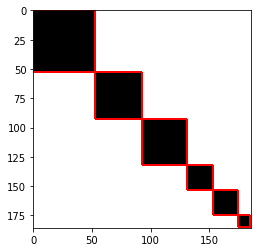

Converged!
Iteration 0
Smallest connected component: 1


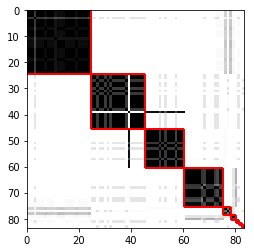

Iteration 1
Smallest connected component: 1


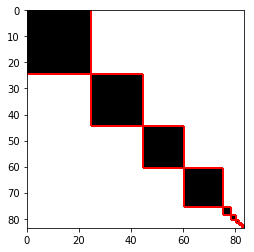

Converged!
Iteration 0
Smallest connected component: 1


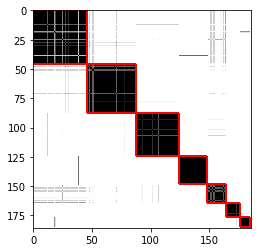

Iteration 1
Smallest connected component: 1


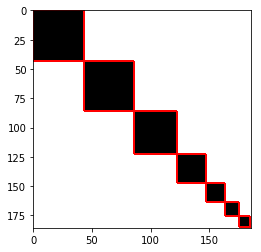

Converged!
Iteration 0
Smallest connected component: 1


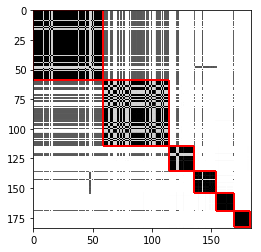

Iteration 1
Smallest connected component: 1


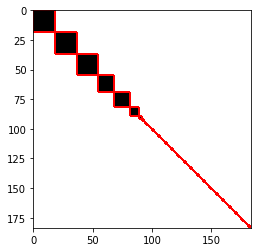

Converged!
Iteration 0
Smallest connected component: 1


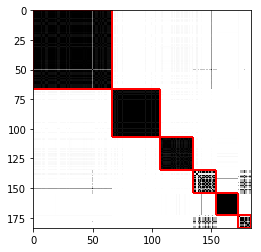

Iteration 1
Smallest connected component: 1


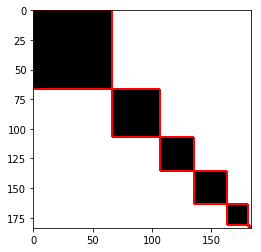

Converged!


In [7]:
consensus_matrices_dict = {}
partition_dict = {}
for year in graphs:
    cons, part = consensus_partition(graphs[year], verbose=True, threshold=0.5, 
                                     nr_partitions=100, weights='Weight',
                                    partition_type=la.RBConfigurationVertexPartition, resolution_parameter=1.5)
    consensus_matrices_dict[year] = cons
    partition_dict[year] = part

In [8]:
# Filter out single communities 
partition_filtered_dict = {}
from collections import Counter
for year in graphs:
    part_sizes = Counter(partition_dict[year])
    partition_filtered_dict[year] = [p if part_sizes[p] > 1 else np.nan for p in partition_dict[year]]

In [9]:
nodes_merged = nodes.copy()

for year in partition_dict:
    consensus_s = pd.Series(partition_filtered_dict[year], index=graphs[year].vs['name'])
    nodes_merged['consensus_{}'.format(year)] = consensus_s
    
nodes_merged = nodes_merged.dropna(subset=['consensus_{}'.format(y) for y in graphs], how='all')

In [10]:
consensus_columns = ['consensus_{}'.format(year) for year in graphs]

In [11]:
def add_statistics(graph, nodes, suffix):
    names = graph.vs.get_attribute_values('name')
    
    nodes['degree_'+suffix] = pd.Series(graph.degree(), index=names)
    nodes['weighted_degree_'+suffix] = pd.Series(graph.strength(weights='Weight'), index=names)
    nodes['eigenvector_centrality_'+suffix] = pd.Series(
        graph.eigenvector_centrality(directed=False, weights='Weight'), index=names)
    nodes['betweenness_'+suffix] = pd.Series(graph.betweenness(directed=False, weights='Distance'), index=names)

In [12]:
for year in graphs.keys():
    add_statistics(graphs[year], nodes_merged, year)

In [13]:
nodes_merged.head()

,Label,latitude,longitude,name,consensus_2011,consensus_1996,consensus_1998,consensus_2006,consensus_2009,consensus_2003,...,eigenvector_centrality_2012,betweenness_2012,degree_2002,weighted_degree_2002,eigenvector_centrality_2002,betweenness_2002,degree_2004,weighted_degree_2004,eigenvector_centrality_2004,betweenness_2004
Id,,,,,,,,,,,,,,,,,,,,,
AE,United Arab Emirates,23.424076,53.847818,United Arab Emirates,3.0,5.0,4.0,5.0,3.0,64.0,...,0.012958,0.0,16.0,1775.1946,0.003632,0.0,25.0,3341.4812,0.006485,0.0
AF,Afghanistan,33.93911,67.709953,Afghanistan,6.0,NaN,NaN,4.0,7.0,79.0,...,0.001037,0.0,9.0,8.8024,0.000013,0.0,20.0,52.7047,0.000133,0.0
AG,Antigua and Barbuda,17.060816,-61.796428,Antigua and Barbuda,2.0,NaN,NaN,6.0,7.0,79.0,...,0.000373,0.0,8.0,6.7451,0.000014,0.0,19.0,192.7468,0.000737,0.0
AI,Anguilla,18.220554,-63.068615,Anguilla,5.0,NaN,NaN,4.0,6.0,NaN,...,0.000017,0.0,7.0,1.6359,0.000004,0.0,16.0,6.0209,0.000018,0.0
AL,Albania,41.153332,20.168331,Albania,0.0,1.0,3.0,1.0,7.0,79.0,...,0.000547,0.0,17.0,477.0706,0.000388,0.0,21.0,574.0981,0.000588,0.0


In [14]:
nodes_merged.sort_values('weighted_degree_2008', ascending=False).head()

,Label,latitude,longitude,name,consensus_2011,consensus_1996,consensus_1998,consensus_2006,consensus_2009,consensus_2003,...,eigenvector_centrality_2012,betweenness_2012,degree_2002,weighted_degree_2002,eigenvector_centrality_2002,betweenness_2002,degree_2004,weighted_degree_2004,eigenvector_centrality_2004,betweenness_2004
Id,,,,,,,,,,,,,,,,,,,,,
US,United States,37.09024,-95.712891,United States,1.0,3.0,2.0,0.0,1.0,77.0,...,1.000000,9262.0,63.0,390250.0436,1.000000,8761.0,68.0,481453.3290,1.000000,6971.0
GB,United Kingdom,55.378051,-3.435973,United Kingdom,6.0,4.0,2.0,6.0,7.0,86.0,...,0.714151,6807.0,87.0,231864.7384,0.735624,2525.0,215.0,335721.3924,0.799032,8527.0
DE,Germany,51.165691,10.451526,Germany,0.0,1.0,3.0,1.0,0.0,79.0,...,0.575589,3458.0,50.0,196719.6207,0.587379,5583.0,59.0,273809.3918,0.617455,3023.0
FR,France,46.227638,2.213749,France,5.0,2.0,1.0,2.0,6.0,NaN,...,0.417971,6474.0,197.0,138509.8428,0.452239,7039.0,214.0,195004.9290,0.459824,6770.0
JP,Japan,36.204824,138.252924,Japan,3.0,5.0,4.0,5.0,3.0,77.0,...,0.446925,726.0,61.0,127464.2401,0.497354,1032.0,66.0,165807.6439,0.493292,1075.0


In [15]:
years = sorted(graphs.keys())
labels_list = []
for year in years:
    col = 'consensus_{}'.format(year)
    s = nodes_merged[col].dropna().reset_index()
    labels_list.append(s.groupby(col)['Id'].apply(set).to_dict())

In [16]:
mappings_list = communities.map_labels_over_time(labels_list, jaccard=True, min_overlap=0.1, character_labels=True)

for year, m in zip(years, mappings_list):
    nodes_merged['consensus_mapped_{}'.format(year)] = [m.get(c, None) for c in 
                                                            nodes_merged['consensus_{}'.format(year)]]

In [18]:
consensus_mapped_columns = ['consensus_mapped_{}'.format(year) for year in graphs]

In [19]:
nodes_merged.head()

,Label,latitude,longitude,name,consensus_2011,consensus_1996,consensus_1998,consensus_2006,consensus_2009,consensus_2003,...,consensus_mapped_2003,consensus_mapped_2004,consensus_mapped_2005,consensus_mapped_2006,consensus_mapped_2007,consensus_mapped_2008,consensus_mapped_2009,consensus_mapped_2010,consensus_mapped_2011,consensus_mapped_2012
Id,,,,,,,,,,,,,,,,,,,,,
AE,United Arab Emirates,23.424076,53.847818,United Arab Emirates,3.0,5.0,4.0,5.0,3.0,64.0,...,c,c,i,c,c,c,c,c,c,c
AF,Afghanistan,33.93911,67.709953,Afghanistan,6.0,NaN,NaN,4.0,7.0,79.0,...,d,k,i,i,i,i,j,j,j,j
AG,Antigua and Barbuda,17.060816,-61.796428,Antigua and Barbuda,2.0,NaN,NaN,6.0,7.0,79.0,...,d,j,j,j,j,j,j,j,i,j
AI,Anguilla,18.220554,-63.068615,Anguilla,5.0,NaN,NaN,4.0,6.0,NaN,...,None,j,k,i,j,k,k,k,k,k
AL,Albania,41.153332,20.168331,Albania,0.0,1.0,3.0,1.0,7.0,79.0,...,d,d,d,d,d,d,j,d,d,d


In [20]:
nodes_merged['longitude'] = nodes_merged['longitude'].astype(float)
nodes_merged['latitude'] = nodes_merged['latitude'].astype(float)

In [21]:
community_labels = set(nodes_merged[consensus_mapped_columns].values.flatten())
community_labels.remove(None)
print(community_labels)

{'i', 'f', 'b', 'a', 'g', 'j', 'k', 'm', 'c', 'd', 'h', 'e', 'l'}


In [22]:
from IPython.display import display
# Insight in each of the communities
#max_community = nodes_merged[consensus_mapped_columns].fillna(-1).values.max()

for comm in sorted(community_labels):
    print('Community {}'.format(comm))
    for year in sorted(graphs.keys()):
        com_att = 'consensus_mapped_{}'.format(year)
        
        nodes_sub = nodes_merged[nodes_merged[com_att]==comm].sort_values('weighted_degree_{}'.format(year), 
                                                                      ascending=False)
        if len(nodes_sub)>0:
            print(year, nodes_sub['name'].head(7).values)
    print('\n')

Community a
1995 ['Italy' 'China' 'Brazil']


Community b
1995 ['Spain' 'Argentina']


Community c
1995 ['Australia' 'New Zealand' 'Singapore' 'Hong Kong' 'South Africa'
 'South Korea' 'Thailand']
1996 ['Japan' 'Hong Kong' 'Singapore' 'South Korea' 'China' 'Taiwan' 'Thailand']
1997 ['Japan' 'Australia' 'Hong Kong' 'Singapore' 'South Korea' 'China' 'Taiwan']
1998 ['Japan' 'Australia' 'South Korea' 'Hong Kong' 'China' 'Singapore' 'Taiwan']
1999 ['Japan' 'South Korea' 'Australia' 'Hong Kong' 'Singapore' 'China' 'Taiwan']
2000 ['Japan' 'Hong Kong' 'South Korea' 'Singapore' 'Australia' 'China' 'Taiwan']
2001 ['Japan' 'Hong Kong' 'Singapore' 'South Korea' 'Australia' 'China' 'Taiwan']
2002 ['Hong Kong' 'Singapore' 'Australia' 'China' 'Thailand' 'India' 'Malaysia']
2003 ['Hong Kong' 'Singapore' 'Australia' 'China' 'Thailand' 'India' 'Malaysia']
2004 ['United States' 'Japan' 'Canada' 'Hong Kong' 'Singapore' 'South Korea'
 'Australia']
2005 ['Japan' 'South Korea' 'Hong Kong' 'Singapore' 'Austra

In [25]:
country_sets_dict = {}
changes = {}
for comm in community_labels:
    print('Community {}'.format(comm))
    df_incom = nodes_merged[consensus_mapped_columns].unstack()
    df_incom = df_incom[df_incom==comm]
    country_sets = {c: set(df_incom.xs(c).index.tolist()) for c in df_incom.index.levels[0]}
    country_sets_dict[comm] = country_sets
    jscores = {c1: {c2: common.jaccard(country_sets[c1], country_sets[c2]) for c2 in country_sets} for c1 in country_sets}
    #display(pd.DataFrame(jscores))
    changes[comm] = np.diag(pd.DataFrame(jscores), 1)
    #print('\n')

Community i
Community f
Community b
Community a
Community g
Community j
Community k
Community m
Community c
Community d
Community h
Community e
Community l


In [26]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [27]:
def plot_communities(nodes, community_col, ax, color_dict, size=None):
    m = Basemap(projection='cyl',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
    m.drawcoastlines(ax=ax, color='grey')
    m.drawcountries(ax=ax, color='grey')

    # Draw the country points
    minsize, maxsize = 30, 160
    if size is None:
        s = (minsize + maxsize)/2
    else:
        s = minsize + np.array(size)*(maxsize-minsize) / (max(size)-min(size))
    
    for com in sorted(color_dict.keys()):
        nodes_sub = nodes[nodes[community_col]==com]
        if len(nodes_sub)>0:
            x, y = m(nodes_sub['longitude'].values, nodes_sub['latitude'].values)
            color = color_dict[com]
            p = m.scatter(x,y,color=color, ax=ax, norm=norm, s=s, label=com)
    ax.legend()
    return m

In [28]:
ncom = len(community_labels)
print('{} distinct communities'.format(ncom))
cmap = plt.cm.get_cmap('gist_ncar')
norm = matplotlib.colors.BoundaryNorm(np.arange(0, ncom+1), ncom)
color_dict = {c: cmap(i/ncom) for (i,c) in enumerate(community_labels)}

13 distinct communities


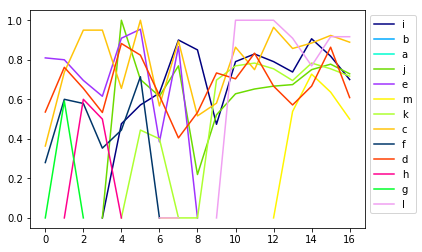

In [29]:
for com in changes:
    plt.plot(changes[com], label=com, color=color_dict[com])
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


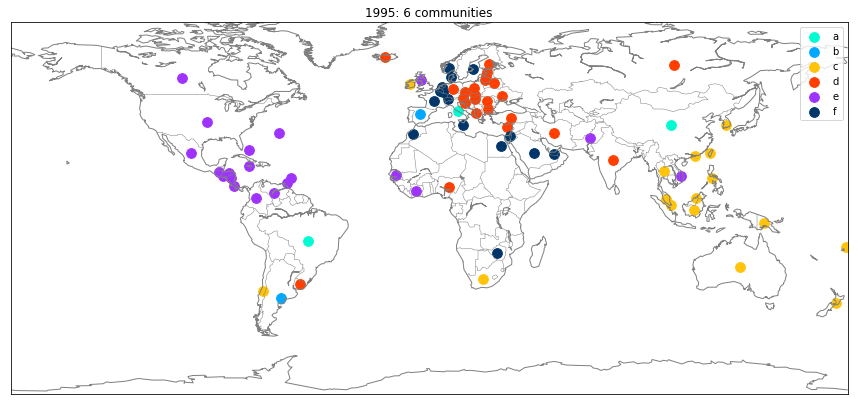

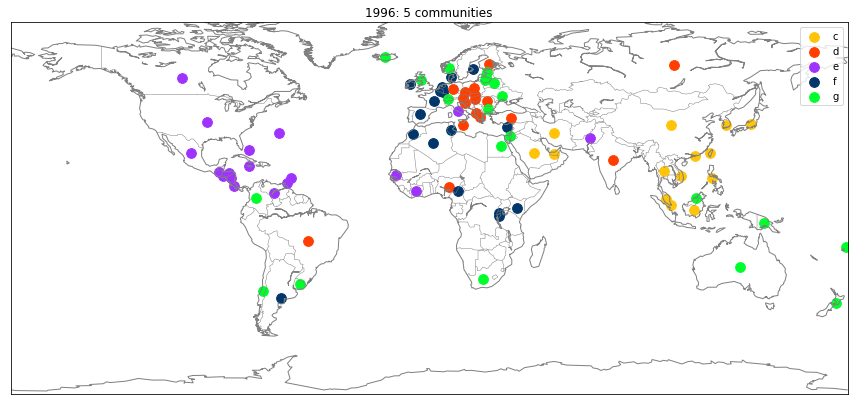

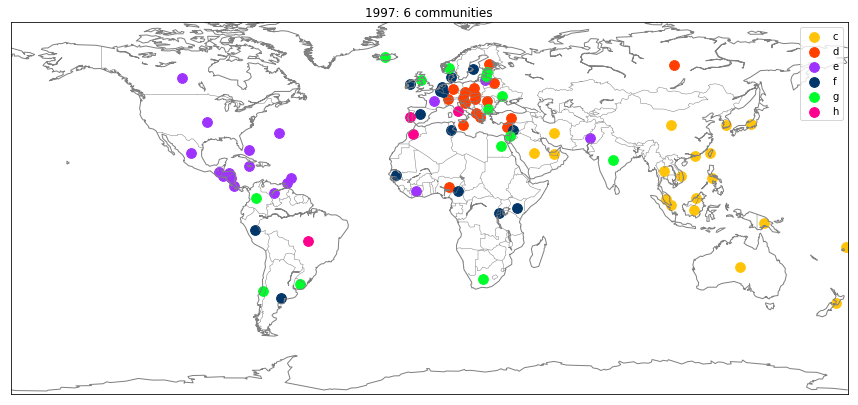

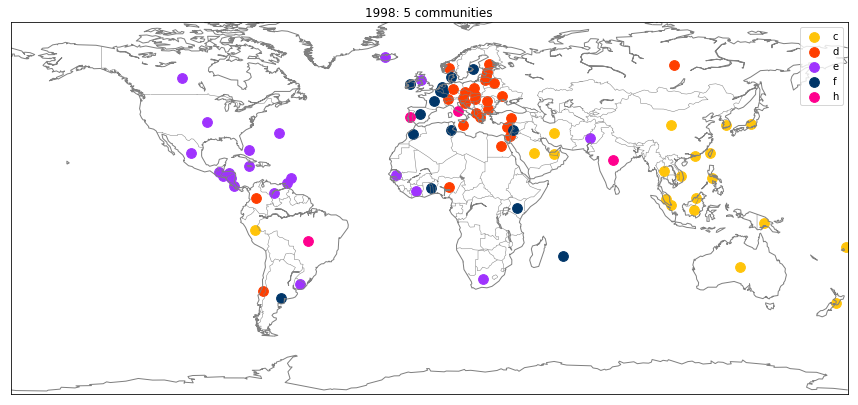

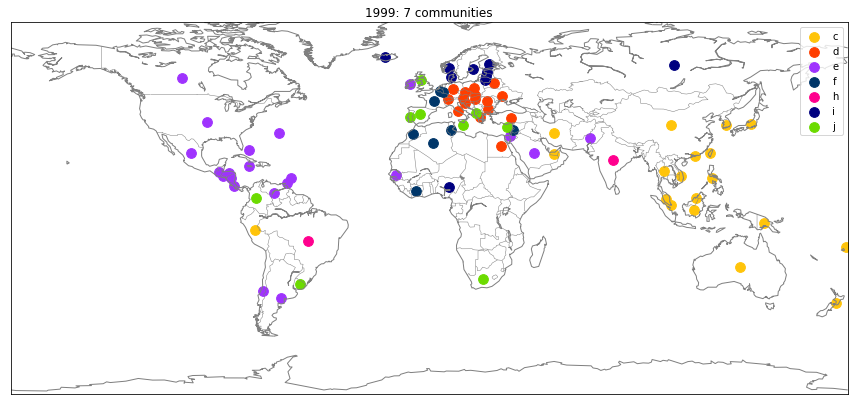

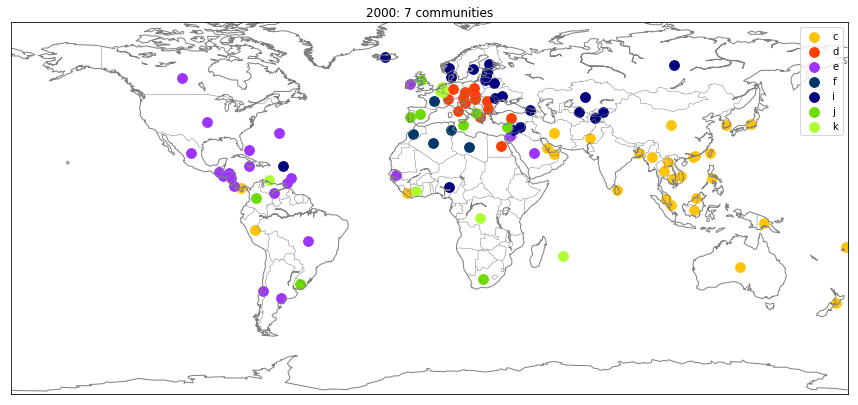

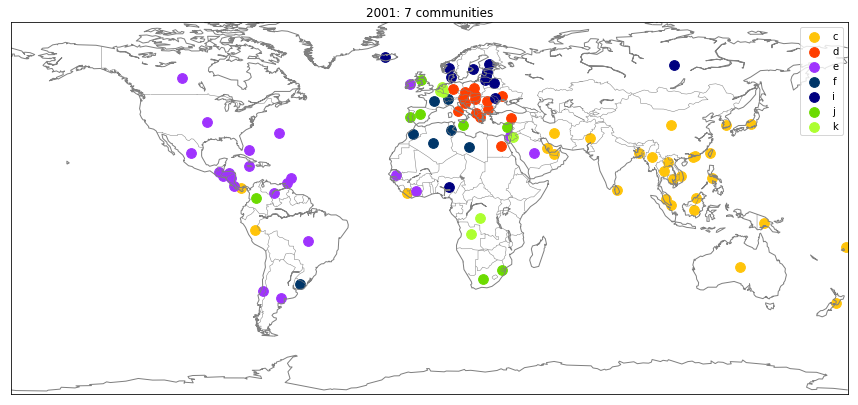

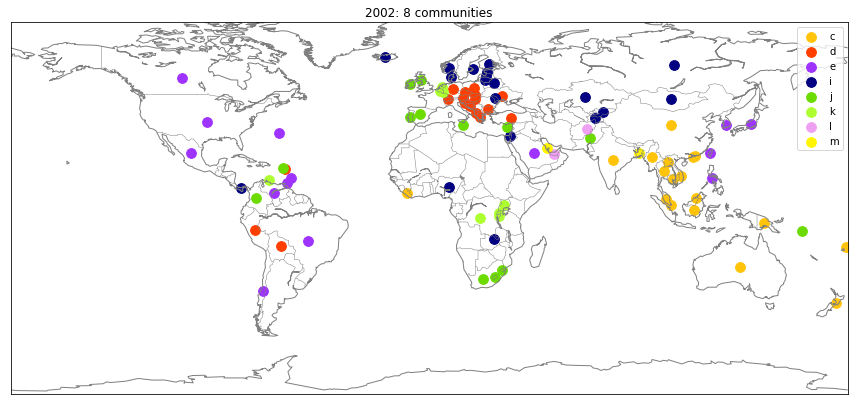

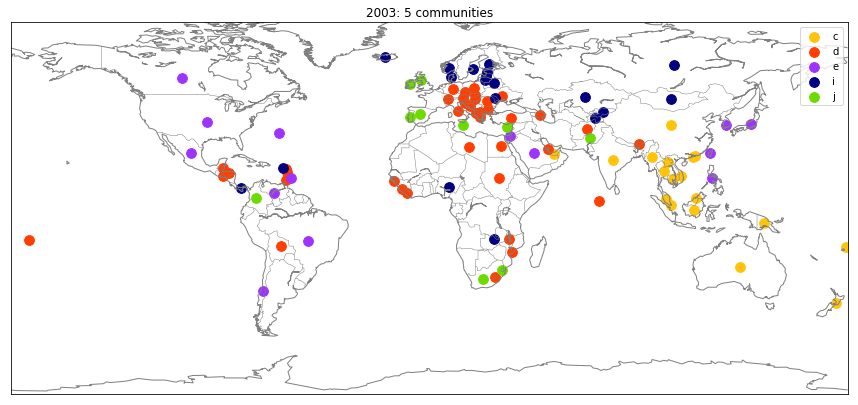

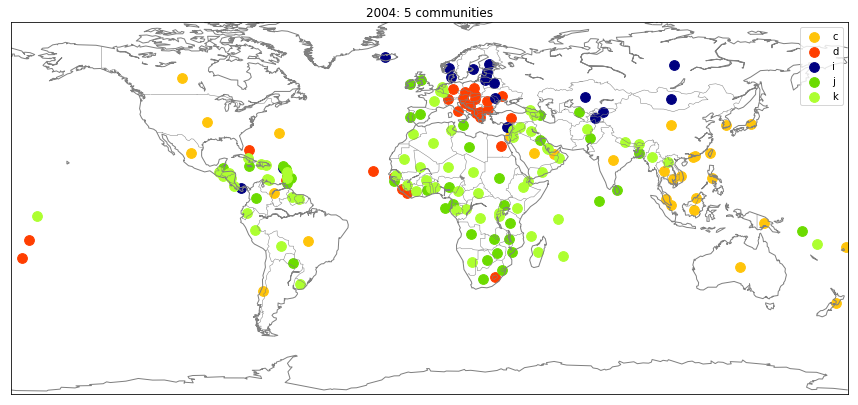

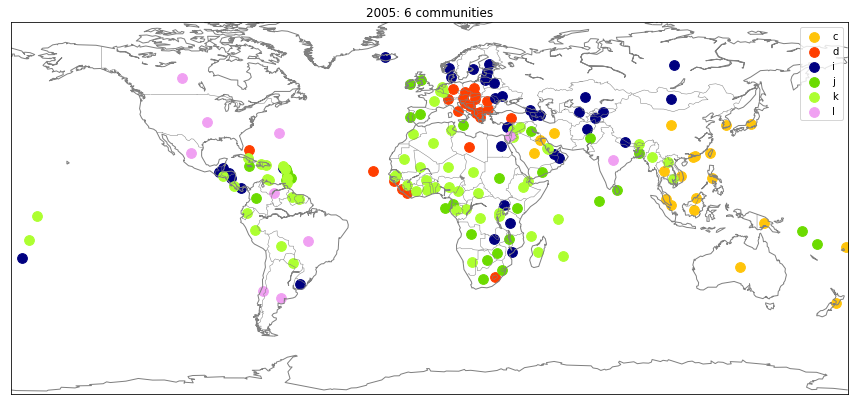

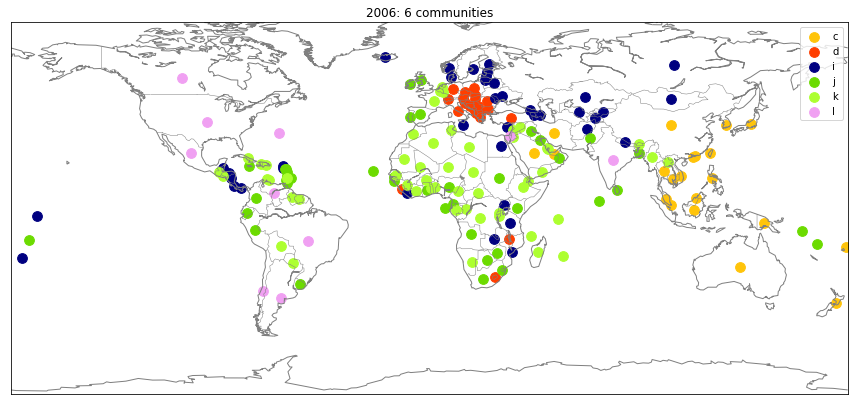

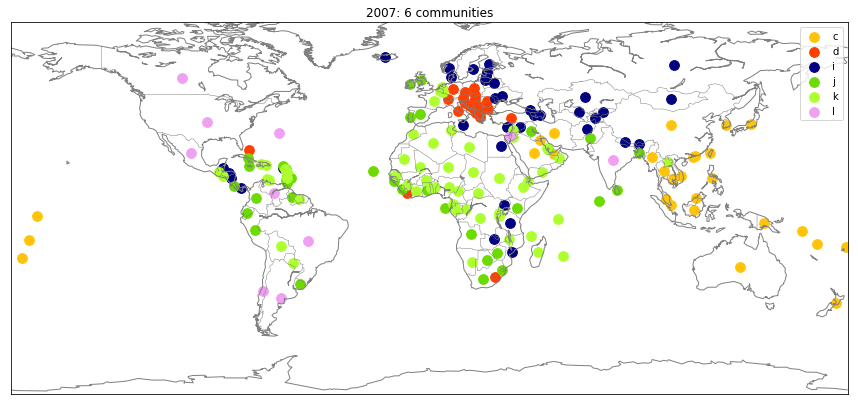

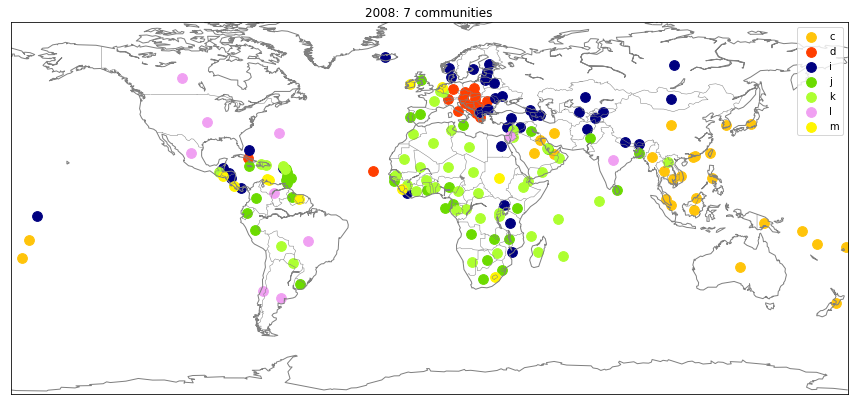

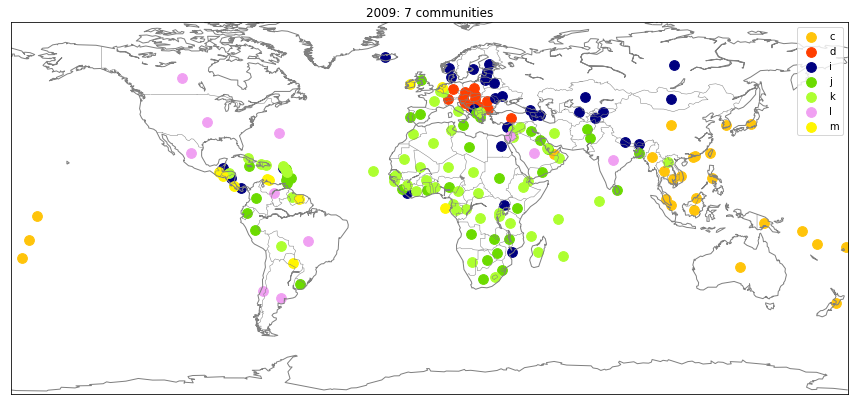

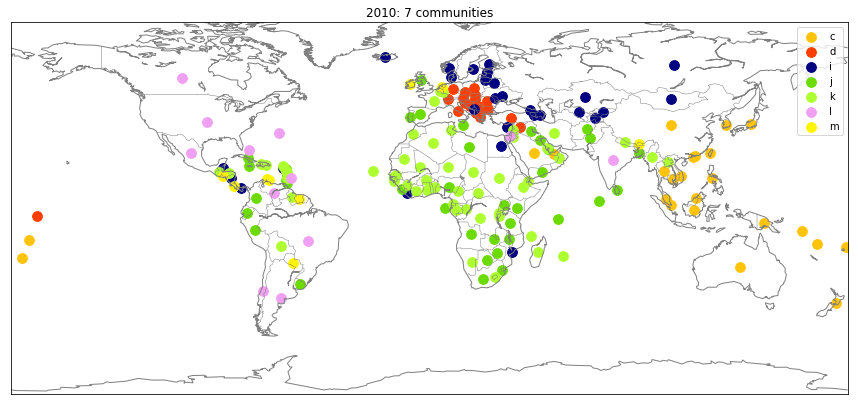

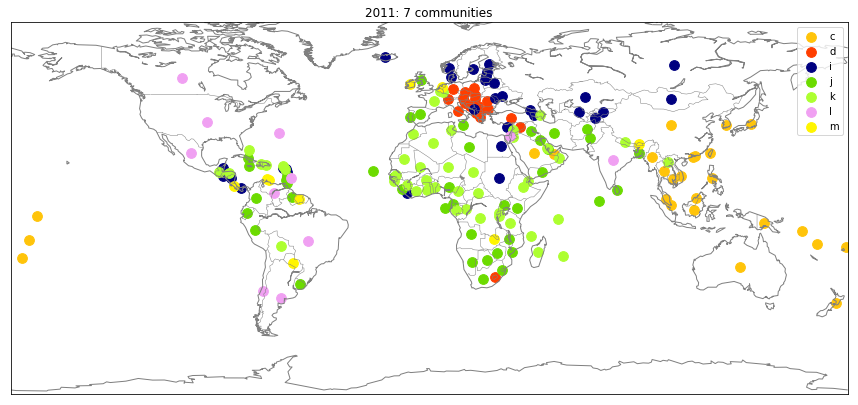

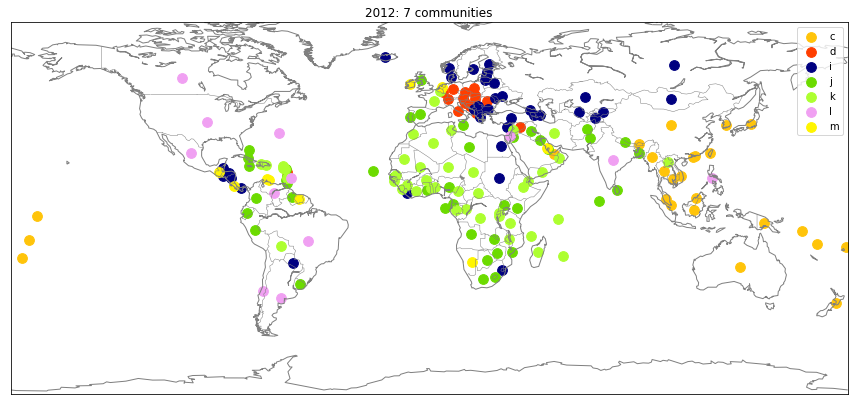

In [30]:
nr_plots = len(graphs)
for i, year in enumerate(sorted(graphs)):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.gca()
    if i<nr_plots:
        att = 'consensus_mapped_{}'.format(year)
        n = nodes_merged[att].nunique()
        m = plot_communities(nodes_merged, att, ax, color_dict=color_dict)
        ax.set_title('{}: {} communities'.format(year, n))
        plt.show()

In [ ]:
ax 